Unzipping /content/result.zip ...
✅ Unzipped to /content/


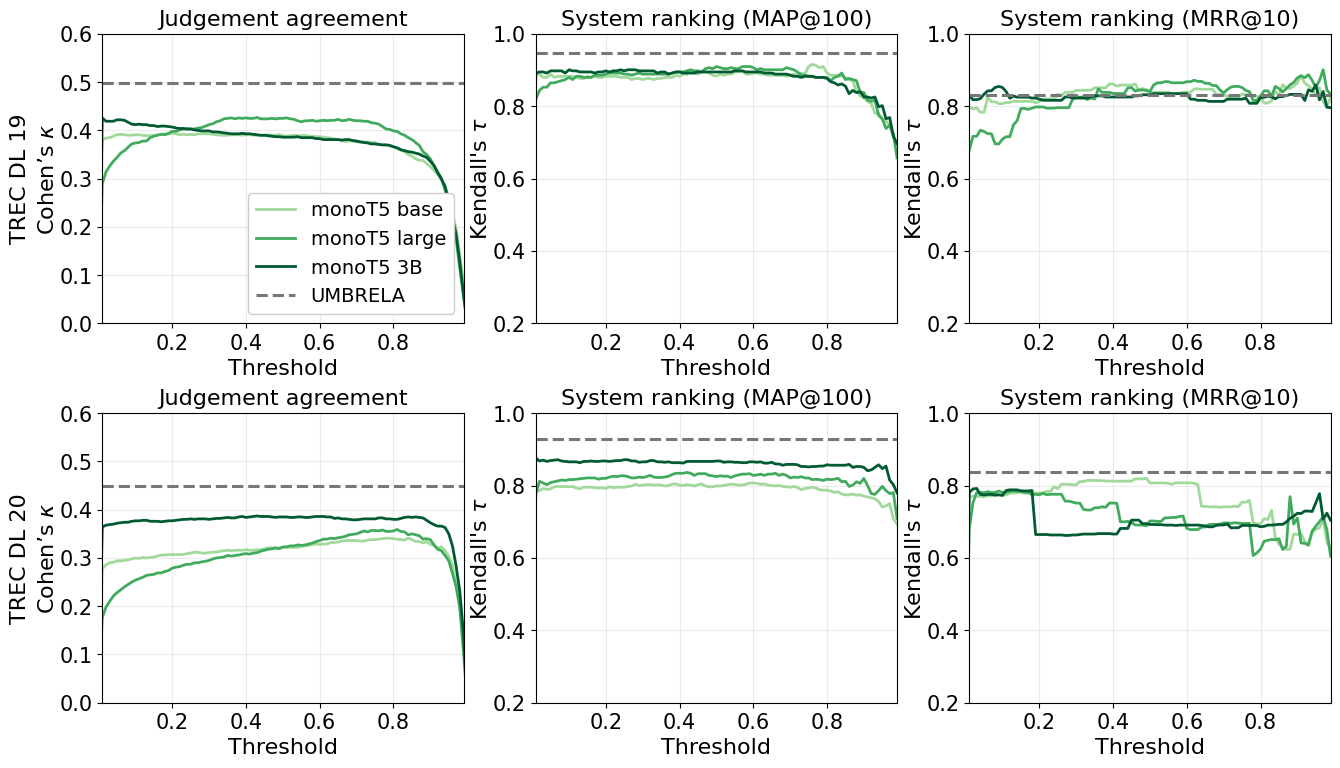

Saved: /content/plots_per_family_pairs/monot5.pair_dl19_dl20-2by3.pdf


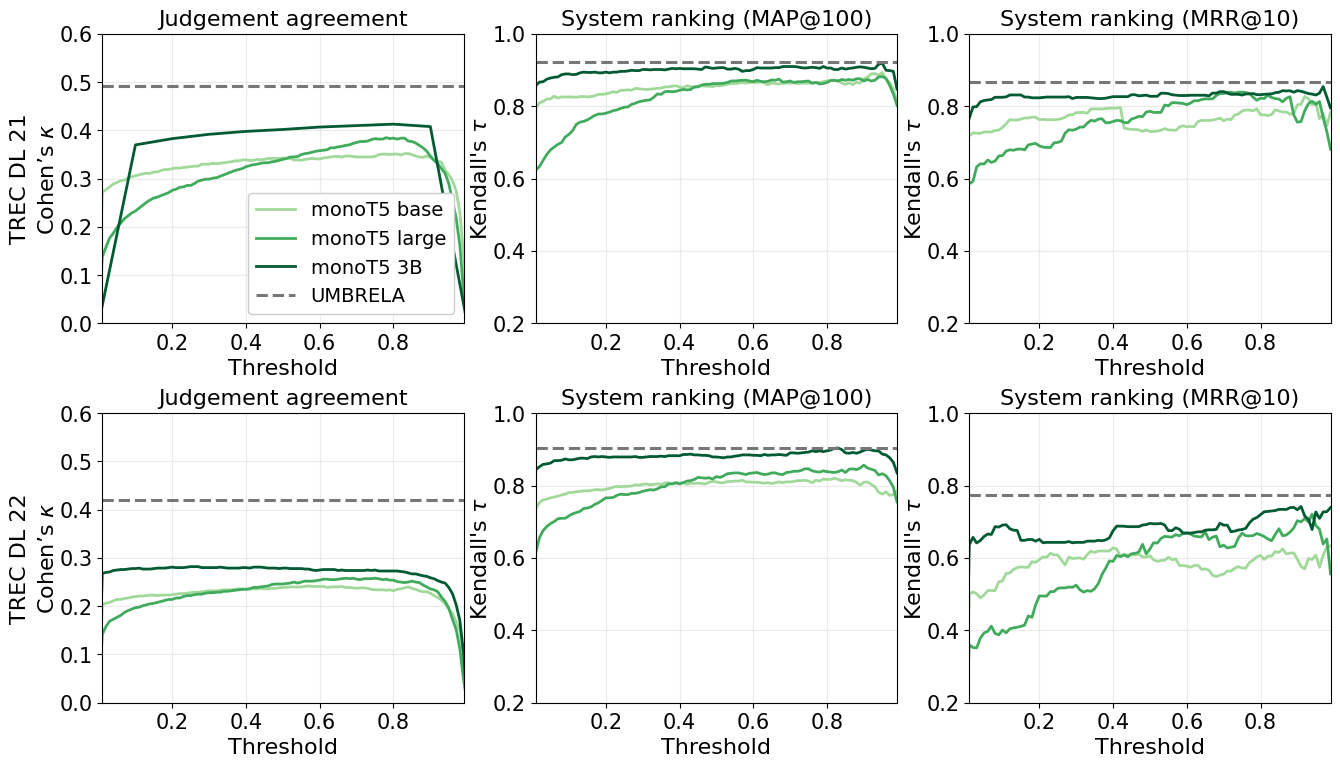

Saved: /content/plots_per_family_pairs/monot5.pair_dl21_dl22-2by3.pdf


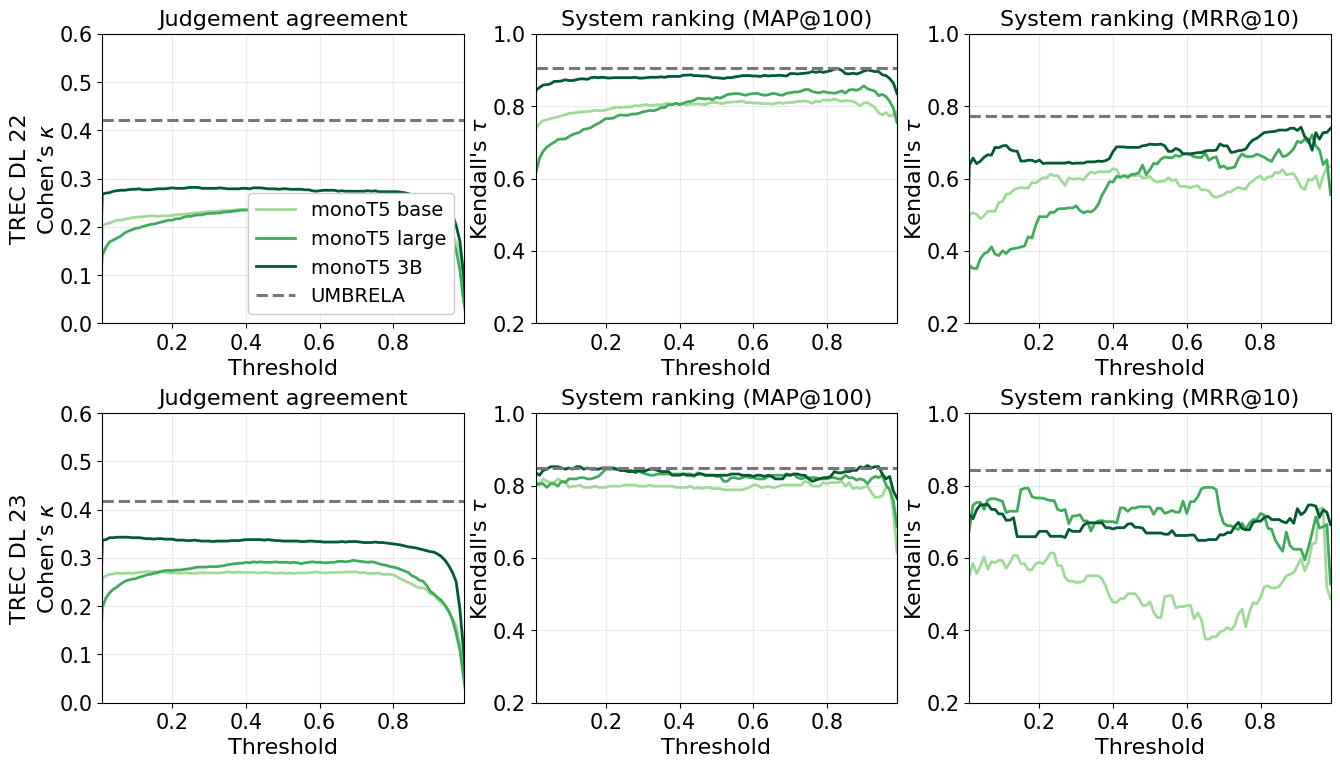

Saved: /content/plots_per_family_pairs/monot5.pair_dl22_dl23-2by3.pdf


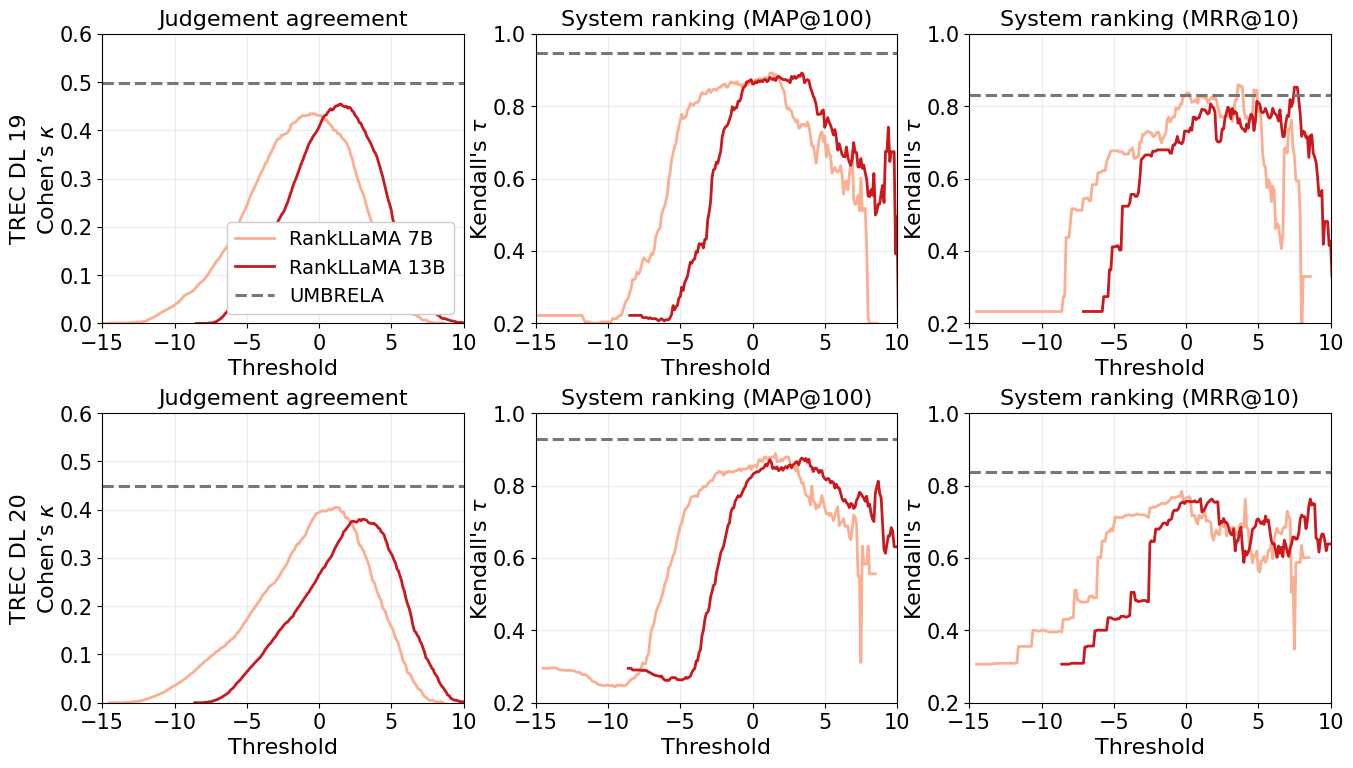

Saved: /content/plots_per_family_pairs/rankllama.pair_dl19_dl20-2by3.pdf


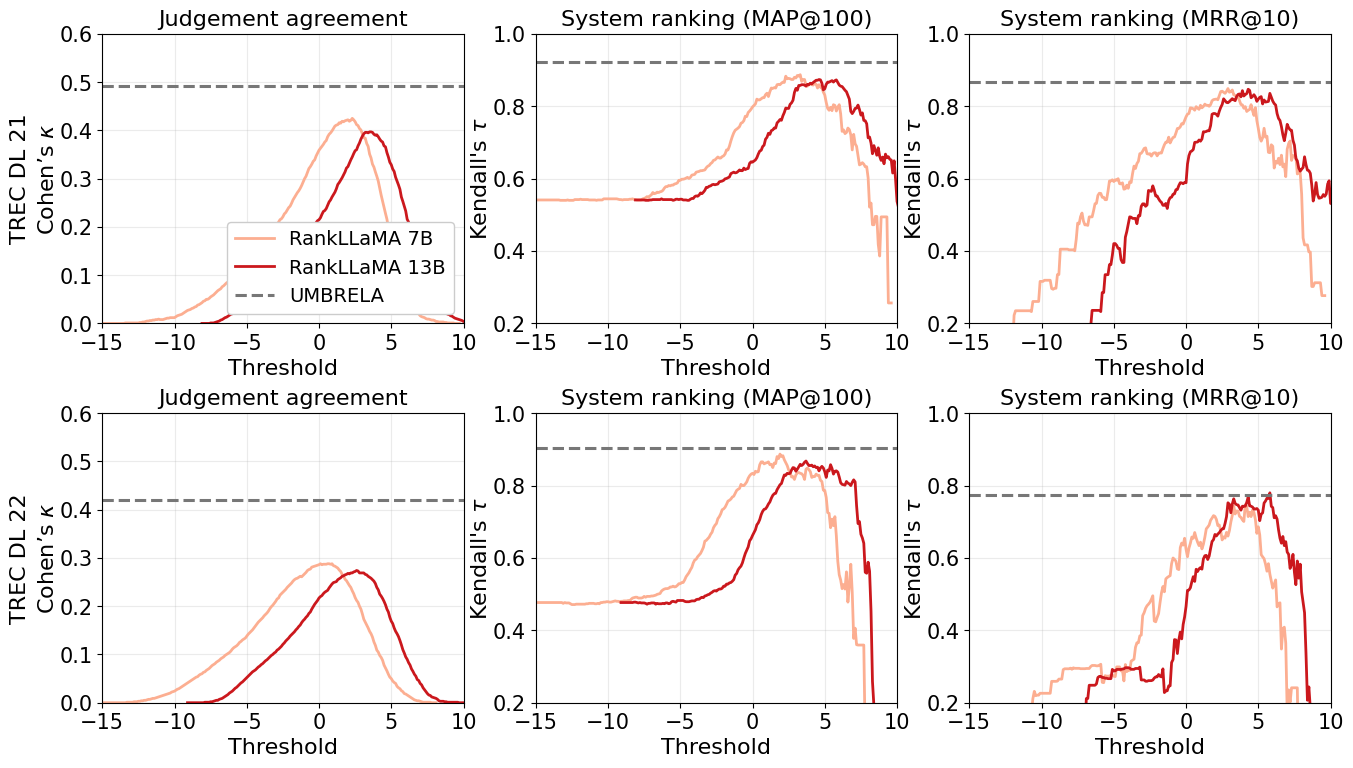

Saved: /content/plots_per_family_pairs/rankllama.pair_dl21_dl22-2by3.pdf


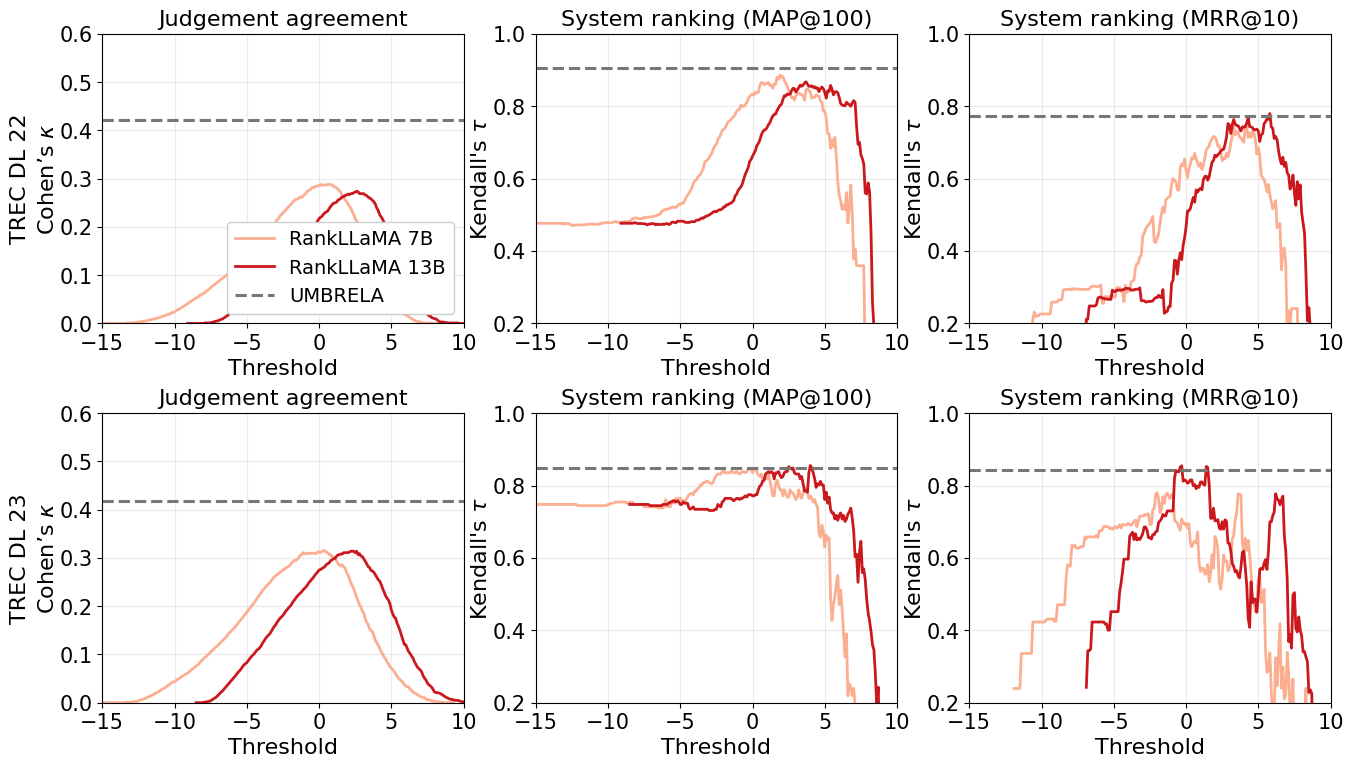

Saved: /content/plots_per_family_pairs/rankllama.pair_dl22_dl23-2by3.pdf


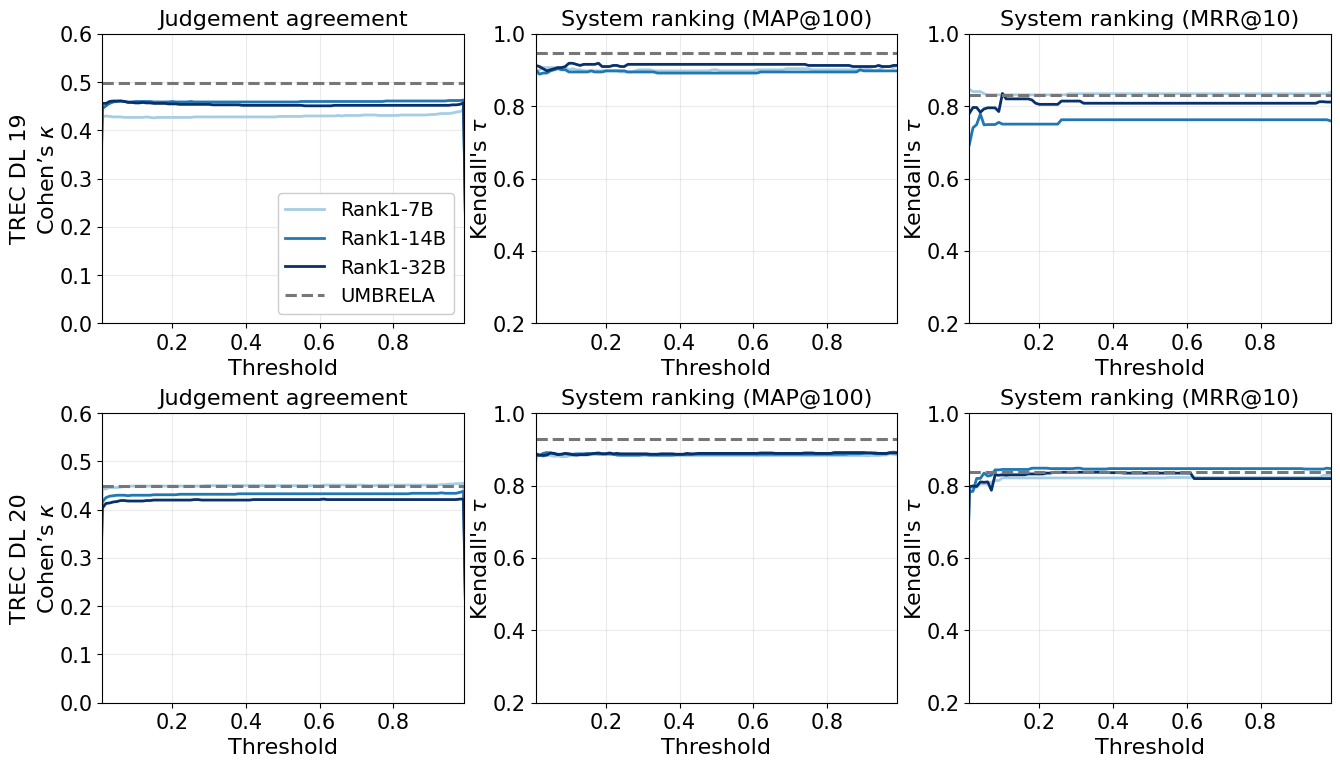

Saved: /content/plots_per_family_pairs/rank1.pair_dl19_dl20-2by3.pdf


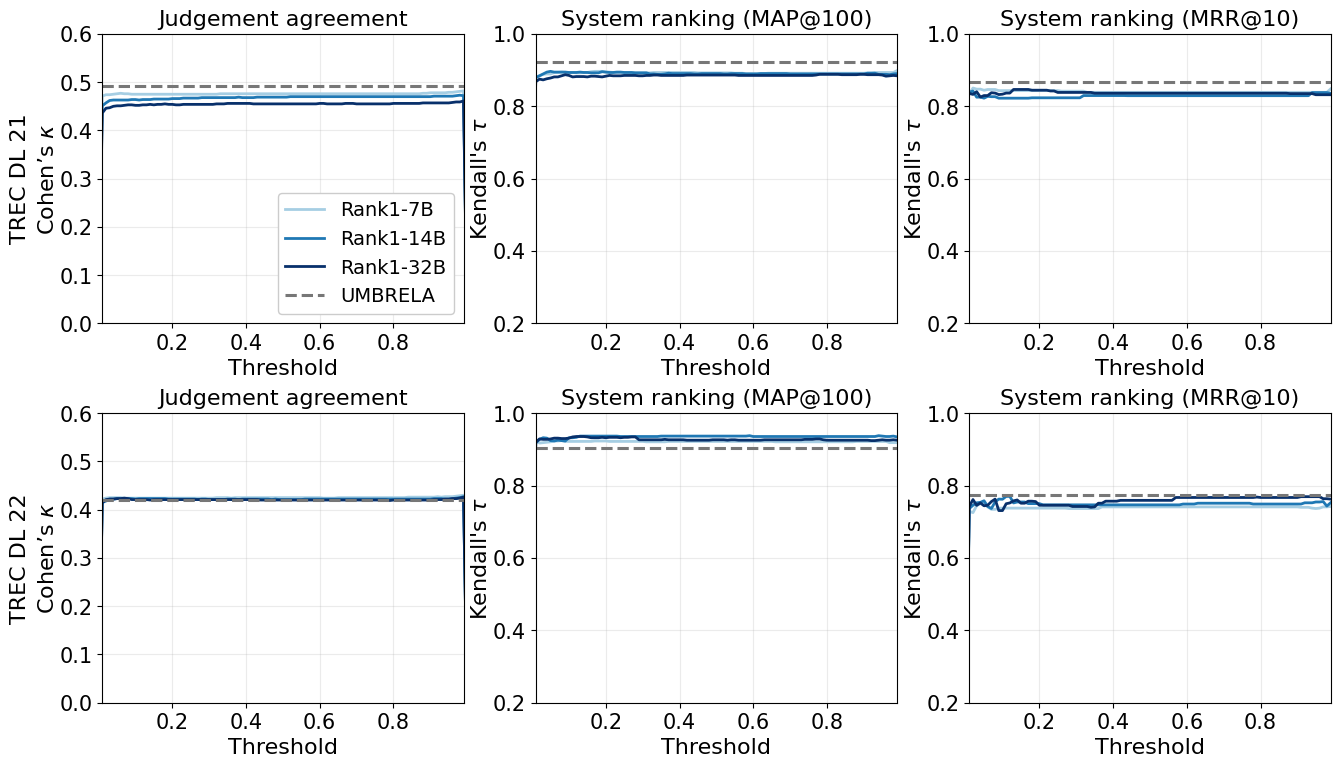

Saved: /content/plots_per_family_pairs/rank1.pair_dl21_dl22-2by3.pdf


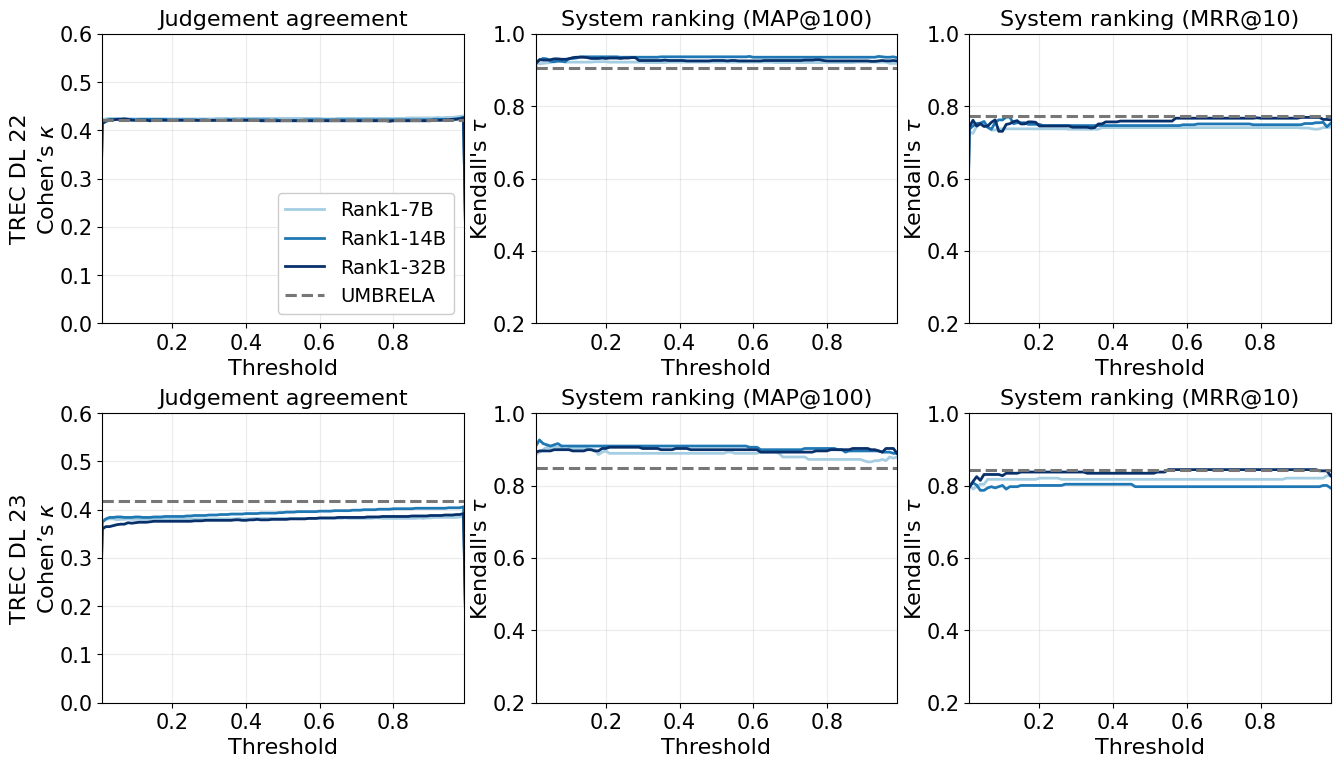

Saved: /content/plots_per_family_pairs/rank1.pair_dl22_dl23-2by3.pdf
✅ 所有图已打包为: /content/plots_per_family_pairs.zip
➡️ 在 Colab 左侧文件浏览器中右键该 zip → Download（下载）


In [ ]:
import os, glob, json, zipfile, shutil
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- Font sizes ----------
TITLE_FS  = 16
LABEL_FS  = 16
TICK_FS   = 15
LEGEND_FS = 14

plt.rcParams.update({
    "axes.titlesize":   TITLE_FS,
    "axes.labelsize":   LABEL_FS,
    "xtick.labelsize":  TICK_FS,
    "ytick.labelsize":  TICK_FS,
    "legend.fontsize":  LEGEND_FS,
})


# ---------- Paths ----------
ROOT  = "./result"
RJ_DIR = os.path.join(ROOT, "rj")
SR_DIR = os.path.join(ROOT, "system_ranking")

# ---------- Datasets & labels ----------
DATASETS = [
    "dl19-passage", "dl20-passage", "dl21-passage",
    "dl22-passage_duped", "dl23-passage_duped",
]
DATASET_LABEL = {
    "dl19-passage": "TREC DL 19",
    "dl20-passage": "TREC DL 20",
    "dl21-passage": "TREC DL 21",
    "dl22-passage_duped": "TREC DL 22",
    "dl23-passage_duped": "TREC DL 23",
}

PAIR_SETS = [
    ("dl19-passage", "dl20-passage"),
    ("dl21-passage", "dl22-passage_duped"),
    ("dl22-passage_duped", "dl23-passage_duped"),
]

# ---------- Kendall's τ metrics ----------
TAU_METRICS = ["map@100", "mrr@10"]

FAMILY_ORDERS = {
    "monot5":    ["monot5-base", "monot5-large", "monot5-3b"],
    "rankllama": ["rankllama-7b", "rankllama-13b"],
    "rank1":     ["rank1-7b", "rank1-14b", "rank1-32b-awq"],
}
FAMILY_DISPLAY = {"monot5": "monoT5", "rankllama": "RankLLaMA", "rank1": "Rank1"}
MODEL_LABEL = {
    "monot5-base":   "monoT5 base",
    "monot5-large":  "monoT5 large",
    "monot5-3b":     "monoT5 3B",
    "rankllama-7b":  "RankLLaMA 7B",
    "rankllama-13b": "RankLLaMA 13B",
    "rank1-7b":      "Rank1-7B",
    "rank1-14b":     "Rank1-14B",
    "rank1-32b-awq": "Rank1-32B",
}

FAMILY_COLORS = {
    "monot5":    ["#a1d99b", "#41ab5d", "#005a32"],
    "rankllama": ["#fcae91", "#cb181d"],
    "rank1":     ["#a6cee3", "#1f78b4", "#08306b"],
}
GPT4O_TAG       = "gpt-4o_0123_100_0_1"
GPT4O_LABEL     = "UMBRELA"
GPT4O_COLOR     = "#777777"
GPT4O_LINESTYLE = "--"

# ---------- Helpers ----------
def parse_filename(fname: str):
    parts = fname.split(".")
    if len(parts) < 4:
        return None, None
    return parts[1], parts[2]

def family_of(model: str):
    if model.startswith("monot5"): return "monot5"
    if model.startswith("rankllama"): return "rankllama"
    if model.startswith("rank1") or model.startswith("mrank1"): return "rank1"
    return "other"

def load_rj(dirpath):
    data = defaultdict(dict)
    if not os.path.isdir(dirpath):
        print("[WARN] RJ dir not found:", dirpath)
        return data
    for path in glob.glob(os.path.join(dirpath, "result.*.json")):
        fname = os.path.basename(path)
        if "gen" in fname:
            continue
        model, dataset = parse_filename(fname)
        if not model: continue
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        for ths, payload in obj.items():
            try: thr = float(ths)
            except: continue
            if isinstance(payload, dict) and "cohen_kappa" in payload:
                data[(dataset, model)][thr] = float(payload["cohen_kappa"])
    return data

def load_sr_metrics(dirpath, metrics):
    tau = {m: defaultdict(dict) for m in metrics}
    if not os.path.isdir(dirpath):
        print("[WARN] system_ranking dir not found:", dirpath)
        return tau
    for path in glob.glob(os.path.join(dirpath, "result.*.json")):
        fname = os.path.basename(path)
        if "gen" in fname: continue
        model, dataset = parse_filename(fname)
        if not model: continue
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        for ths, payload in obj.items():
            if not isinstance(payload, dict): continue
            try: thr = float(ths)
            except: continue
            mset = payload.get("metrics", {})
            for m in metrics:
                md = mset.get(m)
                if isinstance(md, dict) and "kendall_tau" in md:
                    tau[m][(dataset, model)][thr] = float(md["kendall_tau"])
    return tau

def load_gpt4o_tau_for_dataset(dataset: str):
    path = os.path.join(SR_DIR, f"result.{GPT4O_TAG}.{dataset}.json")
    if not os.path.isfile(path): return {}
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    gen = obj.get("gen", {})
    metrics = gen.get("metrics", {})
    vals = {}
    for m in TAU_METRICS:
        md = metrics.get(m, {})
        if "kendall_tau" in md:
            vals[m] = float(md["kendall_tau"])
    return vals

def load_gpt4o_kappa_for_dataset(dataset: str):
    path = os.path.join(RJ_DIR, f"result.{GPT4O_TAG}.{dataset}.json")
    if not os.path.isfile(path): return None
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    gen = obj.get("gen", {})
    return float(gen["cohen_kappa"]) if "cohen_kappa" in gen else None

# ---------- Plot a single panel ----------
def plot_panel(ax, series_dict, dataset, family, y_label, umb_value=None, ylim=(0.0, 1.0)):
    order   = FAMILY_ORDERS.get(family, [])
    palette = FAMILY_COLORS.get(family, [])
    available = [m for (d, m) in series_dict.keys() if d == dataset and family_of(m) == family]
    models = [m for m in order if m in available]
    if not models:
        ax.set_visible(False)
        return False

    for i, m in enumerate(models):
        s = series_dict[(dataset, m)]
        ths = sorted(s.keys())
        if not ths: continue
        color = palette[i] if i < len(palette) else None
        ax.plot(ths, [s[t] for t in ths], "-", lw=2, c=color, label=MODEL_LABEL.get(m, m))

    ax.set_ylabel(y_label, fontsize=LABEL_FS, labelpad=1)
    ax.set_ylim(*ylim)
    if family in ("monot5", "rank1"): ax.set_xlim(0.01, 0.99)
    elif family == "rankllama": ax.set_xlim(-15, 10)
    ax.set_xlabel("Threshold", fontsize=LABEL_FS)
    ax.tick_params(axis='both', which='major', labelsize=TICK_FS)
    ax.grid(alpha=0.25)
    if umb_value is not None:
        x_left, x_right = ax.get_xlim()
        ax.plot([x_left, x_right], [umb_value, umb_value],
                GPT4O_LINESTYLE, lw=2.2, c=GPT4O_COLOR, label=GPT4O_LABEL)
    ax.margins(x=0.06, y=0.06)
    return True

# ---------- Make one 2×3 figure ----------
def make_figure_for_family_pair(family, row_pair, rj_data, tau_data,
                                umb_tau_map, umb_tau_mrr, umb_kap, outdir):
    ds_top, ds_bottom = row_pair
    ds_top_lbl    = DATASET_LABEL.get(ds_top, ds_top)
    ds_bottom_lbl = DATASET_LABEL.get(ds_bottom, ds_bottom)

    # ⬇️
    fig, axes = plt.subplots(2, 3, figsize=(14.2, 7.6))
    fig.subplots_adjust(left=0.13, right=0.995, bottom=0.08, top=0.96,
                        wspace=0.20, hspace=0.31)

    for r in range(2):
        axes[r,0].set_title("Judgement agreement", fontsize=TITLE_FS, pad=6)
        axes[r,1].set_title("System ranking (MAP@100)", fontsize=TITLE_FS, pad=6)
        axes[r,2].set_title("System ranking (MRR@10)", fontsize=TITLE_FS, pad=6)

    plot_panel(axes[0,0], rj_data, ds_top, family, "Cohen’s $\\kappa$", umb_kap.get(ds_top), ylim=(0.0, 0.6))
    plot_panel(axes[0,1], tau_data["map@100"], ds_top, family, "Kendall's $\\tau$", umb_tau_map.get(ds_top), ylim=(0.2, 1.0))
    plot_panel(axes[0,2], tau_data["mrr@10"], ds_top, family, "Kendall's $\\tau$", umb_tau_mrr.get(ds_top), ylim=(0.2, 1.0))

    plot_panel(axes[1,0], rj_data, ds_bottom, family, "Cohen’s $\\kappa$", umb_kap.get(ds_bottom), ylim=(0.0, 0.6))
    plot_panel(axes[1,1], tau_data["map@100"], ds_bottom, family, "Kendall's $\\tau$", umb_tau_map.get(ds_bottom), ylim=(0.2, 1.0))
    plot_panel(axes[1,2], tau_data["mrr@10"], ds_bottom, family, "Kendall's $\\tau$", umb_tau_mrr.get(ds_bottom), ylim=(0.2, 1.0))

    handles, labels = [], []
    for ax in axes.ravel():
        h, l = ax.get_legend_handles_labels()
        for hh, ll in zip(h, l):
            if ll not in labels:
                handles.append(hh); labels.append(ll)
    if labels:
        axes[0,0].legend(handles, labels, fontsize=LEGEND_FS, loc="lower right", framealpha=1.0)

    # indicato
    axes[0,0].text(-0.20, 0.5, ds_top_lbl, transform=axes[0,0].transAxes,
                   ha="right", va="center", rotation=90, fontsize=LABEL_FS)
    axes[1,0].text(-0.20, 0.5, ds_bottom_lbl, transform=axes[1,0].transAxes,
                   ha="right", va="center", rotation=90, fontsize=LABEL_FS)

    os.makedirs(outdir, exist_ok=True)
    def short(ds): return ds.replace("-passage", "").replace("_duped", "")

    out_pdf = os.path.join(outdir, f"{family}.pair_{short(ds_top)}_{short(ds_bottom)}-2by3.pdf")
    plt.savefig(out_pdf, format="pdf", bbox_inches="tight")
    display(fig)
    plt.close(fig)
    print("Saved:", out_pdf)

# ---------- Load ----------
rj_data  = load_rj(RJ_DIR)
tau_data = {m: load_sr_metrics(SR_DIR, [m])[m] for m in TAU_METRICS}
umb_tau_map_all = {}
umb_tau_mrr_all = {}
umb_kap_all = {}
for ds in DATASETS:
    umb_tau = load_gpt4o_tau_for_dataset(ds)
    umb_tau_map_all[ds] = umb_tau.get("map@100") if umb_tau else None
    umb_tau_mrr_all[ds] = umb_tau.get("mrr@10")  if umb_tau else None
    umb_kap_all[ds] = load_gpt4o_kappa_for_dataset(ds)

# ---------- Run ----------
OUTDIR = "/plot/rq2/"
os.makedirs(OUTDIR, exist_ok=True)
for family in ["monot5", "rankllama", "rank1"]:
    for pair in PAIR_SETS:
        make_figure_for_family_pair(family, pair, rj_data, tau_data,
                                    umb_tau_map_all, umb_tau_mrr_all, umb_kap_all, OUTDIR)
